In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
from random import randrange
from IPython.display import display

In [2]:
WIDTH       =   200
HEIGHT      =   100
MINX        =    20
MINY        =    20
MAXX        =    WIDTH-60
MAXY        =    HEIGHT-60
MINSIZE     =    24
MAXSIZE     =    48
NUMCHARS    =     4 # 4 character CAPTCHA
SYMBOL_SIZE =    50
SYMBOL_SET  =    "0123456789"
NUM_SYMBOLS =    len(SYMBOL_SET)
FONTS_DIR   =    "../fonts"

In [3]:
def generate_captcha(return_image=False):
    fonts = [i for i in os.listdir(FONTS_DIR) if i.endswith('.ttf')]
    while True:
        x_pos = 0
        answer = ''
        boxes = []
        img = Image.new('RGB', (WIDTH, HEIGHT), color = (255,255,255))
        canvas = ImageDraw.Draw(img)
        for i in range(NUMCHARS):
            font = ImageFont.truetype(f'{FONTS_DIR}/{fonts[randrange(len(fonts))]}', randrange(MINSIZE,MAXSIZE))
            character = SYMBOL_SET[randrange(NUM_SYMBOLS)]
            answer += character
            x_pos += randrange(10, MINX)
            y_pos = randrange(MINY, MAXY)
            position = (x_pos, y_pos)
            coords = canvas.textbbox(position, character, font)
            canvas.text(position, character, font=font, fill=(0,0,0), anchor="la")
            boxes.append([coords[0]/WIDTH, coords[1]/HEIGHT, coords[2]/WIDTH, coords[3]/HEIGHT])
            x_pos = coords[2]
        x = np.asarray(img).astype(np.float32) / 255.0
        y = np.array(boxes).flatten().astype(np.float32)
        
        if return_image:
            yield x, y, img, answer
        else:
            yield x, y

In [4]:
# Convert normalized boxes [0,1] back to pixel coordinates
def unnormalize_boxes(boxes):
    boxes = boxes.copy()
    boxes[0::4] *= WIDTH
    boxes[1::4] *= HEIGHT
    boxes[2::4] *= WIDTH
    boxes[3::4] *= HEIGHT
    return boxes

In [5]:
# Draw the boxes 
def draw_boxes(image, truth, pred=None):
    canvas = ImageDraw.Draw(image)
    
    # Unnormalize and reshape
    truth_boxes = np.reshape(unnormalize_boxes(truth), (4, 4))
    if pred is not None:
        pred_boxes = np.reshape(unnormalize_boxes(pred), (4, 4))
    
    for i in range(len(truth_boxes)):
        canvas.rectangle(list(truth_boxes[i]), outline="green", width=1)
        print("Truth", i+1, ":", truth_boxes[i])
        if pred is not None:
            canvas.rectangle(list(pred_boxes[i]), outline="red", width=1)
            print("Preds", i+1, ":", pred_boxes[i])

    display(image)

(100, 200, 3)
Truth 1 : [10. 56. 31. 81.]
Truth 2 : [43. 36. 68. 68.]
Truth 3 : [ 79.  42. 101.  62.]
Truth 4 : [120.00001  36.      134.       58.     ]


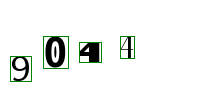

In [6]:
x, y, image, answer = next(generate_captcha(return_image=True))
print(x.shape)
draw_boxes(image, y)

In [7]:
box_model = tf.keras.models.load_model("../models/BBox_Regressor_v2.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Truth 1 : [11. 34. 31. 61.]
Preds 1 : [13.432797 36.02193  30.961796 61.673935]
Truth 2 : [41. 48. 57. 78.]
Preds 2 : [44.845203 45.4346   63.320118 72.24437 ]
Truth 3 : [ 76.  41. 104.  77.]
Preds 3 : [77.30531  43.383907 99.86921  73.60605 ]
Truth 4 : [114.  32. 121.  51.]
Preds 4 : [113.76182   32.497906 125.10439   51.583923]


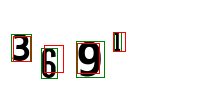

In [8]:
x, y, image, answer = next(generate_captcha(return_image=True))
y_pred = box_model.predict(x.reshape(-1, HEIGHT, WIDTH, 3))[0]
draw_boxes(image, y, y_pred)

In [9]:
test_size = 1000

In [10]:
mae_total = 0
for _ in range(test_size):
    x, y_true, image, answer = next(generate_captcha(return_image=True))
    y_pred = box_model.predict(x.reshape(1, HEIGHT, WIDTH, 3), verbose=False)[0]
    y_true_px = unnormalize_boxes(y_true)
    y_pred_px = unnormalize_boxes(y_pred)
    mae_total += np.mean(np.abs(y_true_px - y_pred_px))
mae = mae_total / test_size
print(f"MAE per coordinate: {mae:.2f} pixels")

MAE per coordinate: 2.42 pixels


In [11]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Then in your loop
iou_scores = []
for _ in range(test_size):
    x, y_true, image, answer = next(generate_captcha(return_image=True))
    y_pred = box_model.predict(x.reshape(1, HEIGHT, WIDTH, 3), verbose=False)[0]
    y_true_px = unnormalize_boxes(y_true)
    y_pred_px = unnormalize_boxes(y_pred)
    for i in range(NUMCHARS):
        b1 = y_true_px[4*i:4*(i+1)]
        b2 = y_pred_px[4*i:4*(i+1)]
        iou_scores.append(compute_iou(b1, b2))
print(f"Average IoU: {np.mean(iou_scores):.2f}")

Average IoU: 0.65


In [12]:
# Evaluate the Bounding Box Regressor
error_margin = 5
count = 0

for i in range(test_size):
    x, y_true, image, answer = next(generate_captcha(return_image=True))
    y_pred = box_model.predict(x.reshape(-1, HEIGHT, WIDTH, 3), verbose=False)[0]
    y_true_px = unnormalize_boxes(y_true)
    y_pred_px = unnormalize_boxes(y_pred)
    count += np.sum(np.abs(y_true_px - y_pred_px) > error_margin)

print("Accuracy of", (test_size-count/16)*100/test_size, "% with error margin of", error_margin, "pixels")

Accuracy of 89.45 % with error margin of 5 pixels


In [13]:
sym_model = tf.keras.models.load_model("../models/Symbol_Recognizer-200epochs.keras")

In [14]:
def captcha_solver(image):
    x = np.asarray(image).astype(np.float32) / 255.0
    y_pred = box_model.predict(x.reshape(-1, HEIGHT, WIDTH, 3), verbose=False)[0]
    boxes = unnormalize_boxes(y_pred)
    sub_images = []
    for i in range(NUMCHARS):
        box = boxes[4*i:4*(i+1)]
        sub_img = image.crop(box).resize((SYMBOL_SIZE, SYMBOL_SIZE))
        tensor = np.asarray(sub_img).astype(np.float32) / 255.0
        sub_images.append(tensor.reshape(SYMBOL_SIZE, SYMBOL_SIZE, 3))
    batch = np.stack(sub_images)
    preds = sym_model.predict(batch, verbose=False)
    return ''.join(str(np.argmax(p)) for p in preds)

count = 0
for i in range(test_size):
    x, y, image, answer = next(generate_captcha(return_image=True))
    solve = captcha_solver(image)
    if answer != solve:
        count += 1

print("Accuracy:", (test_size-count)*100/test_size)

Accuracy: 75.5


In [15]:
def expand_box(box, factor=0.05):
    w, h = box[2] - box[0], box[3] - box[1]
    x_margin = min(5, factor * w)
    y_margin = min(5, factor * h)
    bbox = box + [-x_margin, -y_margin, x_margin, y_margin]
    return bbox

def captcha_solver(image):
    x = np.asarray(image).astype(np.float32) / 255.0
    y_pred = box_model.predict(x.reshape(-1, HEIGHT, WIDTH, 3), verbose=False)[0]
    boxes = unnormalize_boxes(y_pred)
    sub_images = []
    for i in range(NUMCHARS):
        box = boxes[4*i:4*(i+1)]
        sub_img = image.crop(expand_box(box)).resize((SYMBOL_SIZE, SYMBOL_SIZE))
        tensor = np.asarray(sub_img).astype(np.float32) / 255.0
        sub_images.append(tensor.reshape(SYMBOL_SIZE, SYMBOL_SIZE, 3))
    batch = np.stack(sub_images)
    preds = sym_model.predict(batch, verbose=False)
    return ''.join(str(np.argmax(p)) for p in preds)

count = 0
for i in range(test_size):
    x, y, image, answer = next(generate_captcha(return_image=True))
    solve = captcha_solver(image)
    if answer != solve:
        count += 1

print("Accuracy:", (test_size-count)*100/test_size)

Accuracy: 80.8
